### Introduction

In histopathology and biomedical image analysis, morphological metrics provide valuable insights into the geometry and complexity of nuclei which can be used to evaluate nuclear pleomorphism (variation in the size, shape, and staining characteristics of cell nuclei within a population of cells). Histolytics offers a comprehensive suite of morphological metrics to compute for nuclei and other segmented objects. In this workflow, we will demonstrate how to compute these at WSI-scale and visualize the spatial distributions of some of these metrics.

We will use a WSI from that we segmented in [the panoptic segmentation example](../../seg/panoptic_segmentation/) as our input data. We will also be focusing solely on the neoplastic nuclei in this tutorial.

In [1]:
# Install seaborn for visualizing the results.
# !pip install seaborn

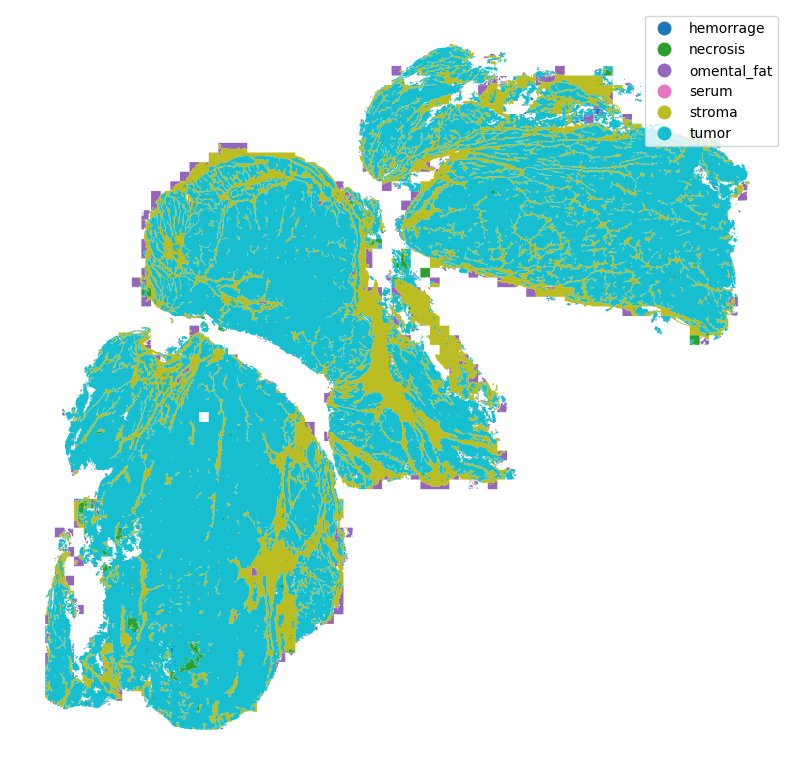

In [ ]:
import geopandas as gpd

nuc = gpd.read_parquet("/path/to/nuclei_seg.parquet")  # <- modify path
tis = gpd.read_parquet("/path/to/tissue_seg.parquet")  # <- modify path

ax = tis.plot(figsize=(10, 10), column="class_name", aspect=1, legend=True)
ax.set_axis_off()

## Computing Morphological Metrics

We will compute all of the different shape morphological metrics that are available in `histolytics` and then visualize some of them. The morphological metrics can be computed with the `shape_metric`-function. The available metrics are:

- Area
- Perimeter
- Solidity
- Major Axis Length
- Minor Axis Length
- Major Axis Angle
- Minor Axis Angle
- Convexity
- Compactness
- Circularity
- Eccentricity
- Elongation
- Equivalent Recatangular Index
- Rectangularity
- Squareness
- Sphericity
- Shape Index
- Fractal Dimension


In [3]:
from histolytics.spatial_geom.shape_metrics import shape_metric

metrics = [
    "area",
    "solidity",
    "major_axis_len",
    "major_axis_angle",
    "minor_axis_len",
    "minor_axis_angle",
    "convexity",
    "compactness",
    "circularity",
    "eccentricity",
    "elongation",
    "equivalent_rectangular_index",
    "rectangularity",
    "squareness",
    "shape_index",
    "fractal_dimension",
]

neo_nuc = nuc[nuc["class_name"] == "neoplastic"]
neo_nuc = shape_metric(neo_nuc, metrics=metrics, parallel=True, num_processes=8)
neo_nuc.head()

,geometry,class_name,id,area,solidity,major_axis_len,major_axis_angle,minor_axis_len,minor_axis_angle,convexity,compactness,circularity,eccentricity,elongation,equivalent_rectangular_index,rectangularity,squareness,shape_index,fractal_dimension
0,"POLYGON ((23532.205 71012.364, 23534.206 71014...",neoplastic,NaN,303.179889,0.996454,21.122759,34.167292,18.632316,55.832708,0.998349,0.928748,0.931822,0.471068,0.896783,0.707009,0.770341,1.182519,0.876445,0.970662
1,"POLYGON ((23538.205 71151.421, 23534.205 71159...",neoplastic,NaN,595.511364,0.998364,38.856234,80.484152,20.130217,9.515848,0.999083,0.816035,0.817533,0.855339,0.572616,0.708278,0.761344,1.039008,0.703120,0.994011
2,"POLYGON ((23526.205 72039.579, 23527.205 72040...",neoplastic,NaN,1668.573991,0.942004,62.826251,70.665622,34.472251,19.334378,0.986742,0.783256,0.804446,0.836025,0.623408,0.738001,0.770433,0.997273,0.730779,1.000368
3,"POLYGON ((23528.964 72615.761, 23528.225 72618...",neoplastic,NaN,687.394834,0.996001,35.221928,84.881615,24.344484,5.118385,0.999539,0.901900,0.902731,0.722688,0.687848,0.735519,0.801664,1.148335,0.796325,0.978828
4,"POLYGON ((23525.205 72869.579, 23527.205 72871...",neoplastic,NaN,985.062835,0.994368,39.643076,38.579682,31.336595,51.420318,0.998415,0.960170,0.963221,0.612503,0.951165,0.712232,0.792948,1.222527,0.889037,0.970850


## Visualizing the Metrics

### Spatial Plots

We will visualize some of the shape metrics of the neoplastic cells. First: **Area** (in pixels)

<AxesHostAxes: xlabel='Area_Minmax'>

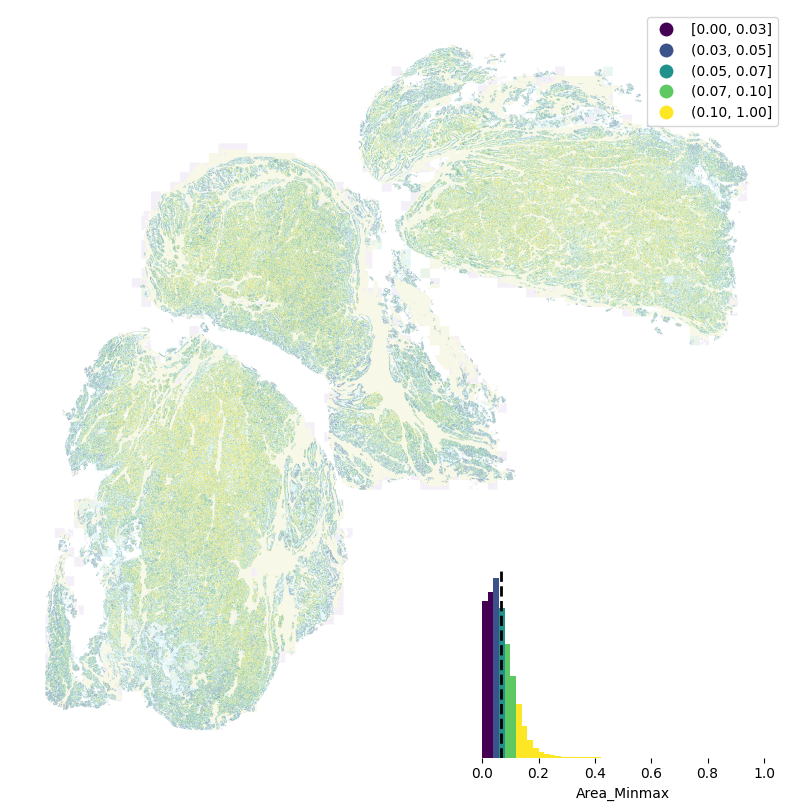

In [4]:
import mapclassify
from histolytics.utils.plot import legendgram
from histolytics.utils.gdf import col_norm


# helper function to replace legend items
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k, v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)


def plot_neoplastic(neoplastic_nuc, col: str = "area", k: int = 5):
    vals = col_norm(neoplastic_nuc[col], "minmax")
    bins = mapclassify.Quantiles(vals, k=k)
    neoplastic_nuc = neoplastic_nuc.assign(bin_vals=bins.yb)
    neoplastic_nuc[f"{col}_minmax"] = vals

    ax = tis.plot(
        figsize=(10, 10), column="class_name", aspect=1, legend=True, alpha=0.1
    )
    ax = neoplastic_nuc.plot(
        ax=ax, column="bin_vals", legend=True, cmap="viridis", categorical=True
    )

    bin_legends = bins.get_legend_classes()
    mapping = dict([(i, s) for i, s in enumerate(bin_legends)])
    replace_legend_items(ax.get_legend(), mapping)
    ax.set_axis_off()

    ax.set_axis_off()

    ax = legendgram(
        gdf=neoplastic_nuc,
        column=f"{col}_minmax",
        n_bins=50,
        breaks=bins.bins,
        cmap="viridis",
        ax=ax,
        loc="lower right",
    )

    return ax


plot_neoplastic(neo_nuc, col="area", k=5)

We can tell that the smaller neoplastic nuclei tend to localize at the border regions of the tumor masses. 

**Eccentricity**

<AxesHostAxes: xlabel='Eccentricity_Minmax'>

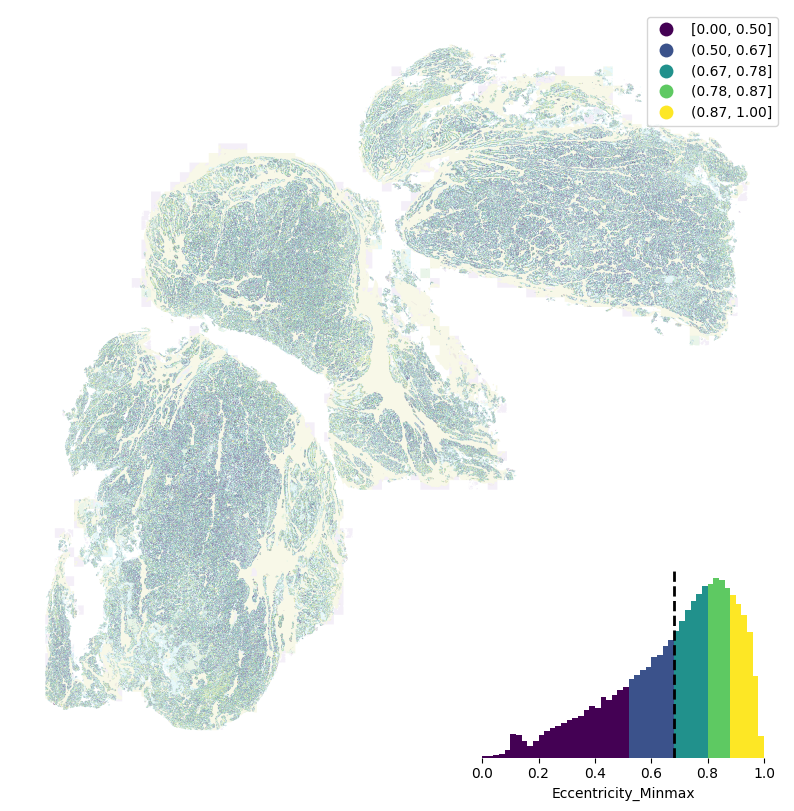

In [5]:
plot_neoplastic(neo_nuc, col="eccentricity", k=5)

**Fractal Dimension**

<AxesHostAxes: xlabel='Fractal_Dimension_Minmax'>

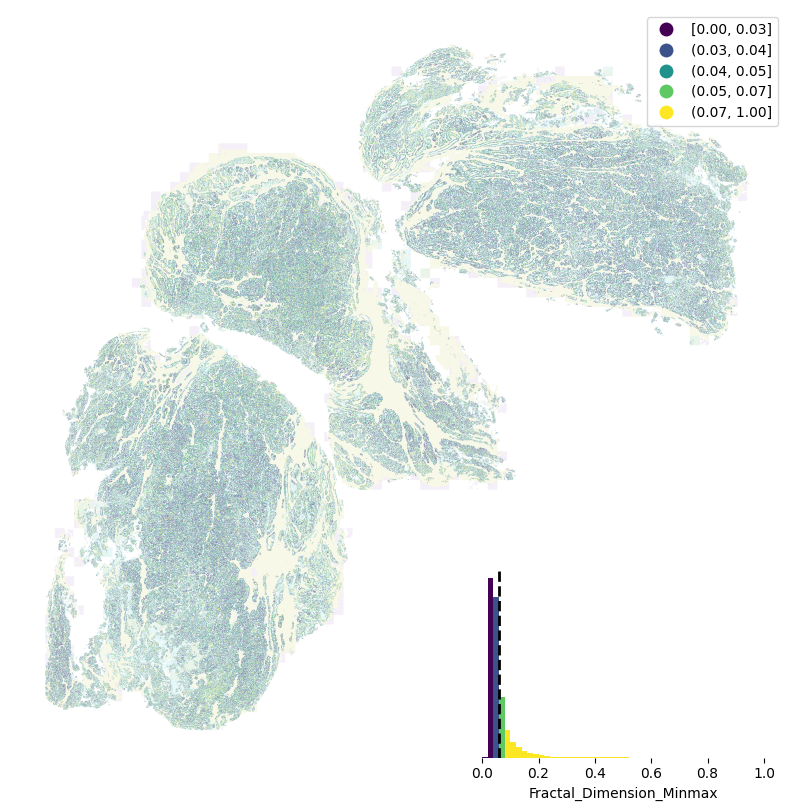

In [6]:
plot_neoplastic(neo_nuc, col="fractal_dimension", k=5)

### Kernel Density Estimation (KDE) Plots

Next, we will look at how the distributions of the different attributes look like when we group the nuclei based on their area bins. Larger nuclei should to have different distributions compared to smaller nuclei, and this can be visualized using KDE plots.

In [7]:
import seaborn


# Let's first define a quick function to plot the data distributions with seaborn
def plot_kde(tidy_data, hue_col):
    seaborn.set_style("whitegrid")
    seaborn.set_theme(font_scale=1.5)

    # Setup the facets
    facets = seaborn.FacetGrid(
        data=tidy_data,
        col="Attribute",
        hue=hue_col,
        sharey=False,
        sharex=False,
        aspect=2,
        col_wrap=2,
    )

    # Build the plot from `sns.kdeplot`
    kde_ax = facets.map(seaborn.kdeplot, "Values", fill=True).add_legend()
    return kde_ax

Let's tidy up the data first

In [8]:
m = list(metrics)

vals = col_norm(neo_nuc["area"], "minmax")
bins = mapclassify.Quantiles(vals, k=5)
neo_nuc = neo_nuc.assign(bin_vals=bins.yb)


tidy = neo_nuc.reset_index().set_index("bin_vals")
tidy = tidy[m]
tidy = tidy.stack()
tidy = tidy.reset_index()
tidy = tidy.rename(
    columns={"bin_vals": "Area Bin", "level_1": "Attribute", 0: "Values"}
)
tidy.head()

,Area Bin,Attribute,Values
0,1,area,303.179889
1,1,solidity,0.996454
2,1,major_axis_len,21.122759
3,1,major_axis_angle,34.167292
4,1,minor_axis_len,18.632316


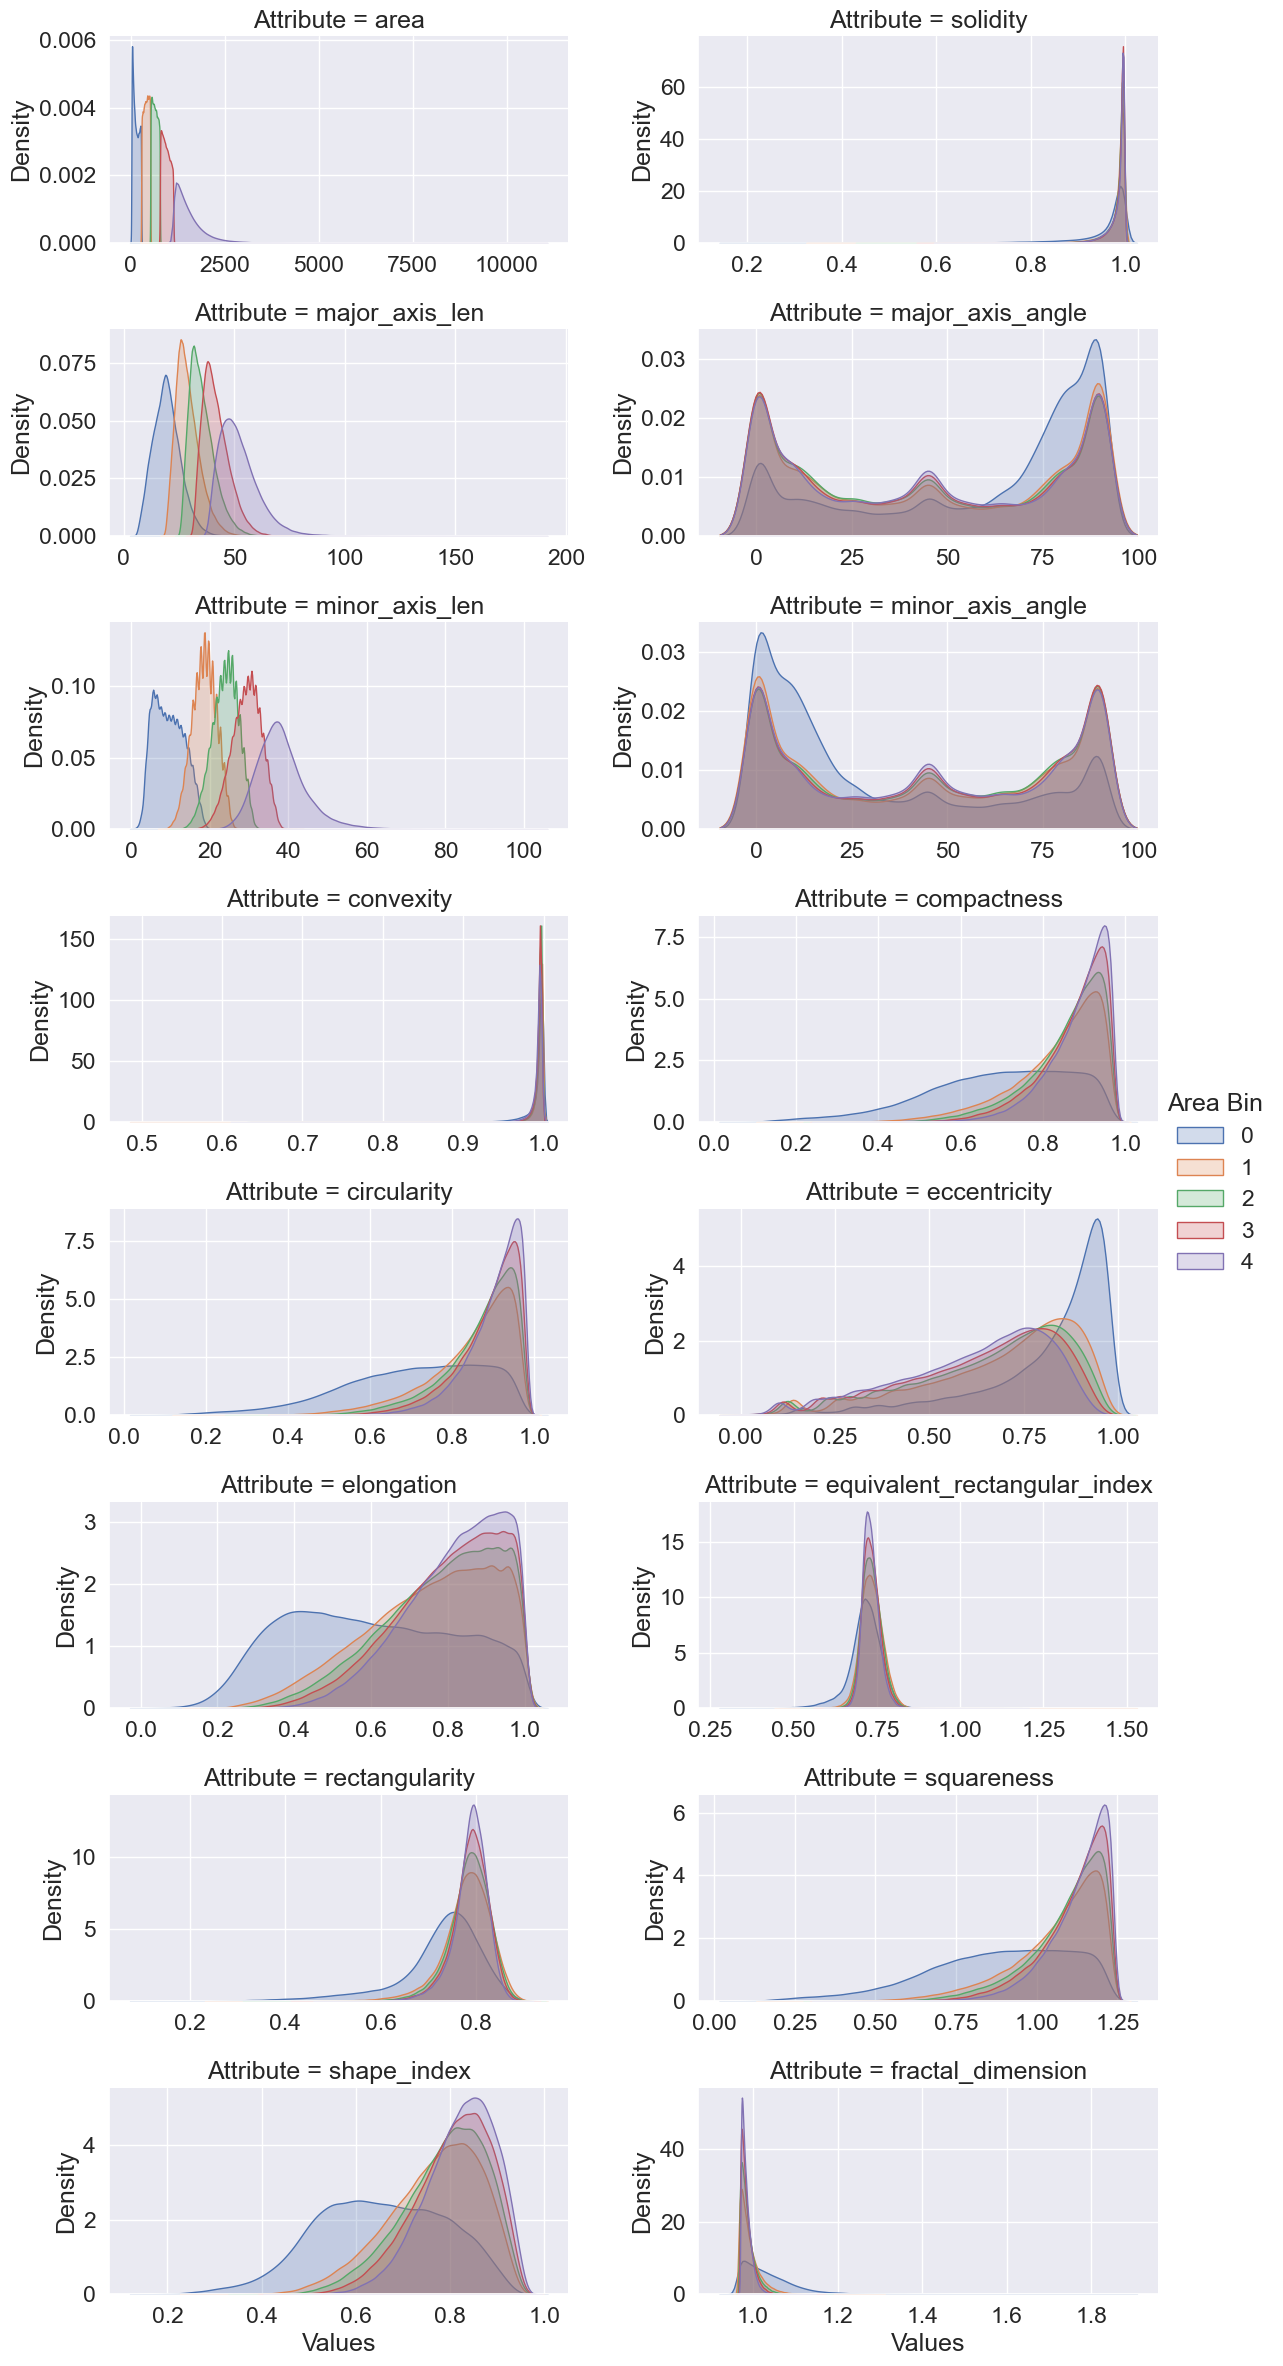

In [9]:
plot_kde(tidy, hue_col="Area Bin")

It looks like smaller nuclei tend to have higher eccentricity and lower circularity overall among the neoplastic nuclei which is an interesting finding. This indicates that the smaller neoplastic nuclei are more elongated and less circular in shape compared to larger neoplastic nuclei.

## Conclusion

In this workflow tutorial we have demonstrated how to compute a wide range of morphological shape metrics for neoplastic nuclei and how to visualize the spatial distributions of selected metrics. This type of analysis can be used to quantify nuclear size and morphology and can be used to evaluate nuclear shape pleomorphism at WSI-scale.